<a href="https://colab.research.google.com/github/brettlaw0111/GoogleColab/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#We need to convert the MNIST images to tensors of 4 dimesnsions (# of images, height, width, color channel)
transform = transforms.ToTensor()


In [3]:
#Train Data
train_data = datasets.MNIST(root = '/cnn_data', train = True, download = True, transform = transform)


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.07MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.01MB/s]


In [4]:
#Test Data
test_data = datasets.MNIST(root = '/cnn_data', train = False, download = True, transform = transform)


In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
#Create a small batch size for images
train_loader = DataLoader(train_data, batch_size = 10, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 10, shuffle = False)

In [8]:
#Define the CNN model
#2 Convolutional layers
#Just an example for now
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)

In [9]:
for i, (X_train, y_train) in enumerate(train_data):
  break

In [10]:
X_train.shape

torch.Size([1, 28, 28])

In [11]:
x = X_train.view(1, 1, 28, 28)

In [12]:
#Perform our first convolution
x = F.relu(conv1(x)) #Rectified Linear Unit for our activation function

In [13]:
#1 single image, 6 is the filters we asked for, 26x26
x.shape

torch.Size([1, 6, 26, 26])

In [14]:
#pass thru the pooling layer
#the 2, 2 "pools" or shrinks the image
x = F.max_pool2d(x, 2, 2) #kernel of 2 and stride of 2

In [15]:
x.shape

torch.Size([1, 6, 13, 13])

In [16]:
#Second convolutional layer
x = F.relu(conv2(x))

In [17]:
x.shape #We didn't set padding so we lose 2 pixels around the outside of the image

torch.Size([1, 16, 11, 11])

In [18]:
#Second pooling layer
x = F.max_pool2d(x, 2, 2)

In [19]:
#11/2 = 5.5. We round down because we would need to invent data to round up
x.shape

torch.Size([1, 16, 5, 5])

In [20]:
#Time for the model class
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)
    #Fully Connected Layer
    #Flatten out to 120 neurons
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)
  #We need a forward function to push all the data through
  def forward(self, X):
    #Rectified Linear Unit
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X,2,2) #2x2 kernel, stride of 2
    #Second pass
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,2,2) #2x2 kernel, stride of 2

    #Re-View to flatten it out
    X = X.view(-1,16*5*5)#Negtive one to vary the batch size

    #Fully COnnected Layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    #We don't need relu since it's the last layer
    X = self.fc3(X)

    #Return the output
    return F.log_softmax(X,dim=1)#Define the dimensions

In [21]:
#Create an instance of the Model
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [22]:
#Loss Function Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)#Smaller LR, longer but better training


In [23]:
X_train.type

<function Tensor.type>

In [24]:
#Letsa train
#Keep track of the time it takes to trin
import time
start_time = time.time()

#Create Variables to track
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

#For loop of epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0
  #Train
  #b is batch
  for b,(X_train, y_train) in enumerate(train_loader):

    b+=1 #Start batches at 1
    y_pred = model(X_train) #Get predicted values from training set. Not flattened. It's 2d because our convolutional layer is looking for 2 dimensions
    loss = criterion(y_pred, y_train) #Compare predictions to correct answers in y_train

    predicted = torch.max(y_pred.data, 1)[1] #Add up the number of correct predictions, indexed off the first point
    batch_corr = (predicted == y_train).sum() #How many did we get correct from this batch? True = 1, False = 0, sum up values
    trn_corr += batch_corr #Keep track of total correct answers throughout training

    #Update parameters

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #Print results

    if b%600 == 0:
      print(f'Epoch: {i}  Batch: {b}  Loss: {loss.item()}')
  train_losses.append(loss)
  train_correct.append(trn_corr)
  #Test

  with torch.no_grad(): #No gradient so we don't update our weights and biases with test data
    for b,(X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1] #Add up correct predictions
      tst_corr += (predicted == y_test).sum() #Same summation as above

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)

current_time = time.time()
total = current_time - start_time
print(f'Training took: {total/60} minutes!')

Epoch: 0  Batch: 600  Loss: 0.16236107051372528
Epoch: 0  Batch: 1200  Loss: 0.15510495007038116
Epoch: 0  Batch: 1800  Loss: 0.4651116728782654
Epoch: 0  Batch: 2400  Loss: 0.17726822197437286
Epoch: 0  Batch: 3000  Loss: 0.007429888937622309
Epoch: 0  Batch: 3600  Loss: 0.37731707096099854
Epoch: 0  Batch: 4200  Loss: 0.004938055761158466
Epoch: 0  Batch: 4800  Loss: 0.0015040982980281115
Epoch: 0  Batch: 5400  Loss: 0.06845302879810333
Epoch: 0  Batch: 6000  Loss: 0.0004587689763866365
Epoch: 1  Batch: 600  Loss: 0.002925408538430929
Epoch: 1  Batch: 1200  Loss: 0.2792360186576843
Epoch: 1  Batch: 1800  Loss: 0.0018853390356525779
Epoch: 1  Batch: 2400  Loss: 0.0030733426101505756
Epoch: 1  Batch: 3000  Loss: 0.024190708994865417
Epoch: 1  Batch: 3600  Loss: 0.5062173008918762
Epoch: 1  Batch: 4200  Loss: 0.02014169655740261
Epoch: 1  Batch: 4800  Loss: 0.001421573688276112
Epoch: 1  Batch: 5400  Loss: 0.0006034405087120831
Epoch: 1  Batch: 6000  Loss: 0.1528162956237793
Epoch: 2  B

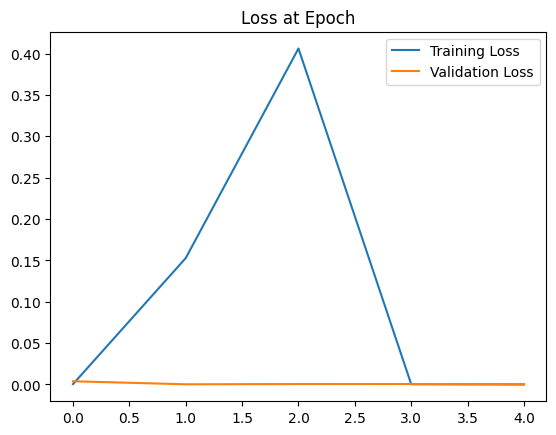

In [25]:
#Let's graph
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label = "Training Loss")
plt.plot(test_losses, label = "Validation Loss")
plt.title("Loss at Epoch")
plt.legend()

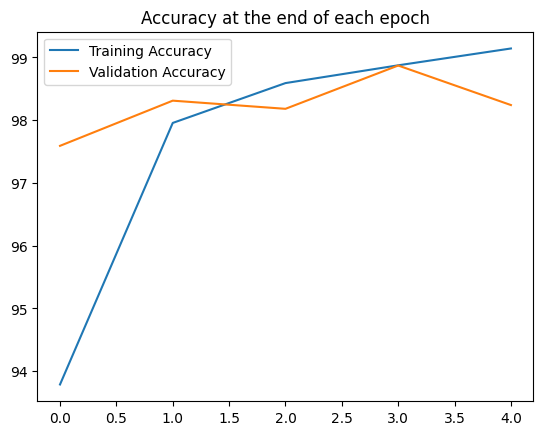

In [26]:
#graph the accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label = "Training Accuracy")
plt.plot([t/100 for t in test_correct], label = "Validation Accuracy")
plt.title("Accuracy at the end of each epoch")
plt.legend()

In [27]:
test_load_everything = DataLoader(test_data, batch_size = 10000, shuffle=False)

In [28]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()

In [29]:
#Did for correct
correct.item()/len(test_data)

0.9824

In [31]:
#Grab an image
test_data[4143] #Tensor with image in it. Shows label at the end

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [32]:
test_data[4143][0] #Just the tensor data

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [33]:
test_data[4143][0].reshape(28,28) #Reshape data to 28x28

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

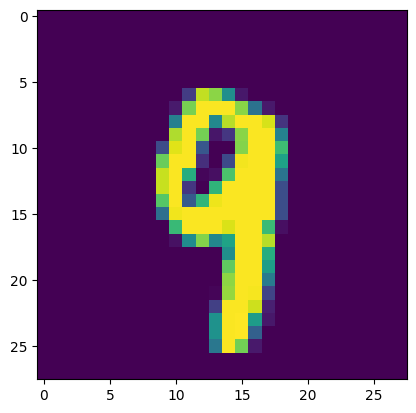

In [35]:
#Show the image
plt.imshow(test_data[4143][0].reshape(28,28))

In [36]:
#Pass the image
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[4143][0].view(1,1,28,28)) #Batch size of 1, 1 color channel, 28x28 image

In [39]:
new_prediction.argmax() #Show the most likely value for the image

tensor(9)